## Face classification

In [15]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import os
import argparse
import numpy as np
import shutil


In [16]:
# Split the dataset into train, test and val folders
args = {"source": "../datasets/black_white", "dest": "../datasets/black_white_splitted", "val_size": 0.1, "train_size": 0.7, "test_size": 0.2}

# Crea le cartelle di destinazione (se non esistono)
if not os.path.exists(args["dest"]):
    os.makedirs(args["dest"])

dest_train = os.path.join(args["dest"], "train")
if not os.path.exists(dest_train):
    os.makedirs(dest_train)

dest_test = os.path.join(args["dest"], "test")
if not os.path.exists(dest_test):
    os.makedirs(dest_test)

dest_val = os.path.join(args["dest"], "val")
if not os.path.exists(dest_val):
    os.makedirs(dest_val)

class_dirs = os.listdir(args["source"])
for class_dir in class_dirs:
    class_dir_path = os.path.join(args["source"], class_dir)
    num_elem = len(os.listdir(class_dir_path))
    total_indices = np.arange(num_elem)
    val_indices = np.random.choice(total_indices,
                                   size=int(num_elem*args["val_size"]),
                                   replace=False)
    total_indices = np.delete(total_indices, val_indices)
    test_indices = np.random.choice(total_indices,
                                   size=int(num_elem*args["test_size"]),
                                   replace=False)

    os.mkdir(os.path.join(dest_train, class_dir))
    os.mkdir(os.path.join(dest_test, class_dir))
    os.mkdir(os.path.join(dest_val, class_dir))
    for index, filename in enumerate(os.listdir(class_dir_path)):
            if index in val_indices:
                shutil.copy(os.path.join(class_dir_path, filename), os.path.join(dest_val, class_dir))
            elif index in test_indices:
                shutil.copy(os.path.join(class_dir_path, filename), os.path.join(dest_test, class_dir))
            else:
                shutil.copy(os.path.join(class_dir_path, filename), os.path.join(dest_train, class_dir))

### Image dataset transforms
The `torchvision.transforms` module includes additional classes specific for image pre-processing. Some of them are:

- `Resize`: resizes an image;
- `RandomCrop`: randomly crops an image (data augmentation during training);
- `RandomHorizontalFlip`: randomly flips an image (data augmentation during training);
- `CenterCrop`: crops the central area of an image (used in testing, as counterpart to `RandomCrop`);
- `Normalize`: performs standardization, given per-channel means and standard deviations.

Usually, to do data augmentation, you crop an image to an area which is slightly smaller than the full size.

In [3]:
# Params
resize = T.Resize(32)  
random_crop = T.RandomCrop(28)             # train
random_hor_flip = T.RandomHorizontalFlip()  # train
center_crop = T.CenterCrop(28)             # test and val
to_tensor = T.ToTensor()
normalize = T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))

# Compose transforms
train_transform = T.Compose([resize, random_crop, random_hor_flip, to_tensor, normalize])
test_transform = T.Compose([resize, center_crop, to_tensor, normalize])
val_transform = T.Compose([resize, center_crop, to_tensor, normalize])

In [4]:
# Instantiate datasets
root_dir = "../datasets/"
train_dataset = ImageFolder(os.path.join(root_dir, "black_white", "train"), transform=train_transform) 
val_dataset = ImageFolder(os.path.join(root_dir, "black_white", "valid"), transform=val_transform)
test_dataset = ImageFolder(os.path.join(root_dir, "black_white", "test"), transform=test_transform) 

# Get number of classes (we'll need it in the model)
num_classes = len(train_dataset.classes)
batch_size = 64

# Print dataset statistics
print(f"Num. classes: {num_classes}")
print(f"Num. train samples: {len(train_dataset)}")
print(f"Num. valid. samples: {len(val_dataset)}")
print(f"Num. test samples: {len(test_dataset)}")

# def loader(path):
#    print(path)
#    return PIL.Image.open(path).convert("RGB")

# Instantiate data loaders
loaders = {"train": DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True),
           "val":   DataLoader(dataset=val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
           "test":  DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
          }

Num. classes: 2
Num. train samples: 70000
Num. valid. samples: 10000
Num. test samples: 20000


In [5]:
# Get image size ("size" is a property of PIL.Image)
train_dataset[0][0].size()

torch.Size([3, 28, 28])

In [6]:
# Show an image of a given class
train_dataset[train_dataset.targets.index(1)][0]

tensor([[[ 0.7096,  0.6778,  0.6778,  ...,  1.0271,  1.3129,  1.4875],
         [ 0.5826,  0.6461,  0.6461,  ...,  0.8525,  1.2018,  1.4082],
         [ 0.6143,  0.5667,  0.2650,  ...,  0.6620,  1.0747,  1.3129],
         ...,
         [-0.6241, -0.2113,  0.2333,  ...,  1.6781,  1.7257,  1.7257],
         [-0.7035, -0.4335, -0.0525,  ...,  1.5987,  1.5193,  1.4399],
         [-0.7352, -0.6241, -0.3383,  ..., -0.4812, -0.8146, -0.9575]],

        [[ 0.7591,  0.7268,  0.7268,  ...,  1.0819,  1.3724,  1.5499],
         [ 0.6300,  0.6946,  0.6946,  ...,  0.9044,  1.2594,  1.4692],
         [ 0.6623,  0.6139,  0.3073,  ...,  0.7107,  1.1303,  1.3724],
         ...,
         [-0.5965, -0.1769,  0.2750,  ...,  1.7435,  1.7920,  1.7920],
         [-0.6772, -0.4028, -0.0155,  ...,  1.6629,  1.5822,  1.5015],
         [-0.7094, -0.5965, -0.3060,  ..., -0.4512, -0.7901, -0.9354]],

        [[ 0.8436,  0.8135,  0.8135,  ...,  1.1441,  1.4145,  1.5798],
         [ 0.7233,  0.7834,  0.7834,  ...,  0

### CNN model

In [7]:
# Import
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
# Define class
class CNN(nn.Module):
    
    # Constructor
    def __init__(self):
        # Call parent constructor
        super().__init__();
        # Create convolutional layers
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            # Layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        # Create fully-connected layers
        self.fc_layers = nn.Sequential(
            # FC layer
            nn.Linear(4096, 1024),
            nn.ReLU(),
            # Classification layer
            nn.Linear(1024, 2)
        )

    # Forward
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

### Model training

In [9]:
# Select device
print(f"CUDA is available? {torch.cuda.is_available()}")
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

CUDA is available? True
cuda


In [13]:
def train(epochs, dev, lr=0.001):
    try:
        # Create model
        model = CNN()
        model = model.to(dev)
        print(model)
        # Optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for i,(input, labels) in enumerate(loaders[split]):
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = model(input)
                    loss = F.cross_entropy(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                    
                    # print batch info
                    #if(i%10 == 0):
                    #    print(f"Batch number: {i} | Loss: {loss}")
                    
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2, bias=True)
  )
)
Epoch 1: TrL=0.6186, TrA=0.6598, VL=0.6118, VA=0.6756, TeL=0.5990, TeA=0.6853,
Epoch 2: TrL=0.5881, TrA=0.6928, VL=0.5817, VA=0.7030, TeL=0.5721, TeA=0.7088,
Epoch 3: TrL=0.5764, TrA=0.7041, VL=0.5719, VA=0.7098, TeL=0.5623, TeA=0.7157,
Epoch 4: TrL=0.5643, TrA=0.7139, VL=0.5607, VA=0.7121, TeL=0.5499, TeA=0.7230,
Epoch 5: TrL=0.5513, TrA=0.7232, VL=0.5534, VA=0.7204, TeL

Epoch 96: TrL=0.2493, TrA=0.8919, VL=0.2787, VA=0.8800, TeL=0.2796, TeA=0.8761,
Epoch 97: TrL=0.2489, TrA=0.8917, VL=0.2717, VA=0.8813, TeL=0.2712, TeA=0.8805,
Epoch 98: TrL=0.2459, TrA=0.8935, VL=0.2701, VA=0.8826, TeL=0.2709, TeA=0.8812,
Epoch 99: TrL=0.2462, TrA=0.8939, VL=0.2800, VA=0.8779, TeL=0.2818, TeA=0.8750,
Epoch 100: TrL=0.2442, TrA=0.8936, VL=0.2727, VA=0.8814, TeL=0.2733, TeA=0.8820,


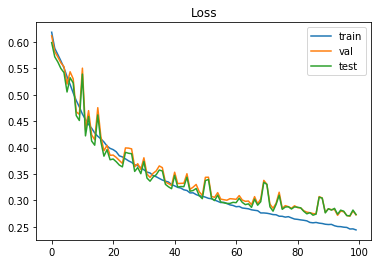

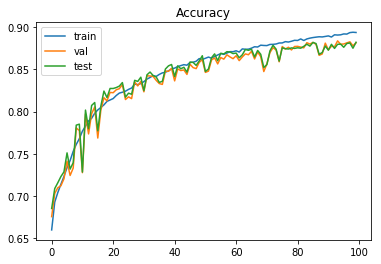

In [14]:
train(100, dev, 0.01)